<a href="https://colab.research.google.com/github/Kinnaruo/DeepLearning/blob/main/Week%203/SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

In [4]:
# TensorFlow
(ds_train, ds_test), ds_info = tfds.load(
    'svhn_cropped',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset_pt = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset_pt = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_loader_pt = DataLoader(train_dataset_pt, batch_size=64, shuffle=True)
test_loader_pt  = DataLoader(test_dataset_pt, batch_size=64, shuffle=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.K4O31Z_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.K4O31Z_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.K4O31Z_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


100%|██████████| 182M/182M [00:25<00:00, 7.19MB/s]
100%|██████████| 64.3M/64.3M [00:16<00:00, 4.00MB/s]


# TensorFlow

In [5]:
cnn_tf = models.Sequential([
    layers.Rescaling(1./255, input_shape=(32, 32, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

mlp_tf = models.Sequential([
    layers.Rescaling(1./255, input_shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# PyTorch

In [6]:
class CNN_PT(nn.Module):
    def __init__(self):
        super(CNN_PT, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self._to_linear = None

        self._get_flatten_size()
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MLP_PT(nn.Module):
    def __init__(self):
        super(MLP_PT, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# Training

In [7]:
# TensorFlow
cnn_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_tf.fit(ds_train.batch(64), epochs=10, validation_data=ds_test.batch(64))
mlp_tf.fit(ds_train.batch(64), epochs=10, validation_data=ds_test.batch(64))


Epoch 1/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 107s 91ms/step - accuracy: 0.5422 - loss: 1.3809 - val_accuracy: 0.8032 - val_loss: 0.7049
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 100s 87ms/step - accuracy: 0.8483 - loss: 0.5464 - val_accuracy: 0.8482 - val_loss: 0.5529
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 140s 86ms/step - accuracy: 0.8722 - loss: 0.4567 - val_accuracy: 0.8600 - val_loss: 0.5115
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 109s 95ms/step - accuracy: 0.8880 - loss: 0.3985 - val_accuracy: 0.8636 - val_loss: 0.4914
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - accuracy: 0.8991 - loss: 0.3568 - val_accuracy: 0.8686 - val_loss: 0.4703
Epoch 6/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 100s 87ms/step - accuracy: 0.9066 - loss: 0.3273 - val_accuracy: 0.8766 - val_loss: 0.4513
Epoch 7/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 140s 86ms/step - accuracy: 0.9126 - loss: 0.3020 - val_accuracy: 0.8768 - val_loss: 0.4556
Epoch 8/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 

In [8]:
# PyTorch
def train_pt(model, train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed")

In [9]:
cnn_pt = CNN_PT()
mlp_pt = MLP_PT()
train_pt(cnn_pt, train_loader_pt)
train_pt(mlp_pt, train_loader_pt)

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed


# Evaluasi Model

In [10]:
def evaluate_tf(model, ds_test, model_name="Model"):
    y_true, y_pred, y_proba = [], [], []
    for x, y in ds_test.batch(64):
        pred = model.predict(x)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(pred, axis=1))
        y_proba.extend(pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    y_true_bin = label_binarize(y_true, classes=list(range(10)))

    print(f"\n📊 Evaluation Results for {model_name} (TensorFlow)")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall   :", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score :", f1_score(y_true, y_pred, average='macro'))
    print("AUC      :", roc_auc_score(y_true_bin, y_proba, multi_class='ovr'))


def evaluate_pt(model, loader, model_name="Model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred, y_proba = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            y_proba.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    y_true_bin = label_binarize(y_true, classes=list(range(10)))

    print(f"\n📊 Evaluation Results for {model_name} (PyTorch)")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall   :", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score :", f1_score(y_true, y_pred, average='macro'))
    print("AUC      :", roc_auc_score(y_true_bin, y_proba, multi_class='ovr'))


In [11]:
evaluate_tf(cnn_tf, ds_test, model_name="CNN_TF")
evaluate_tf(mlp_tf, ds_test, model_name="MLP_TF")
evaluate_pt(cnn_pt, test_loader_pt, model_name="CNN_PT")
evaluate_pt(mlp_pt, test_loader_pt, model_name="MLP_PT")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━

In [12]:
def plot_roc_tf(model, ds_test, model_name):
    y_true, y_proba = [], []
    for x, y in ds_test.batch(64):
        pred = model.predict(x)
        y_true.extend(y.numpy())
        y_proba.extend(pred)

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    y_true_bin = label_binarize(y_true, classes=list(range(10)))

    fpr, tpr, aucs = {}, {}, {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        aucs[i] = roc_auc_score(y_true_bin[:, i], y_proba[:, i])

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {aucs[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} (TensorFlow)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_pt(model, loader, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_proba = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_proba.extend(probs)
            y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    y_true_bin = label_binarize(y_true, classes=list(range(10)))

    fpr, tpr, aucs = {}, {}, {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        aucs[i] = roc_auc_score(y_true_bin[:, i], y_proba[:, i])

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {aucs[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} (PyTorch)')
    plt.legend()
    plt.grid(True)
    plt.show()

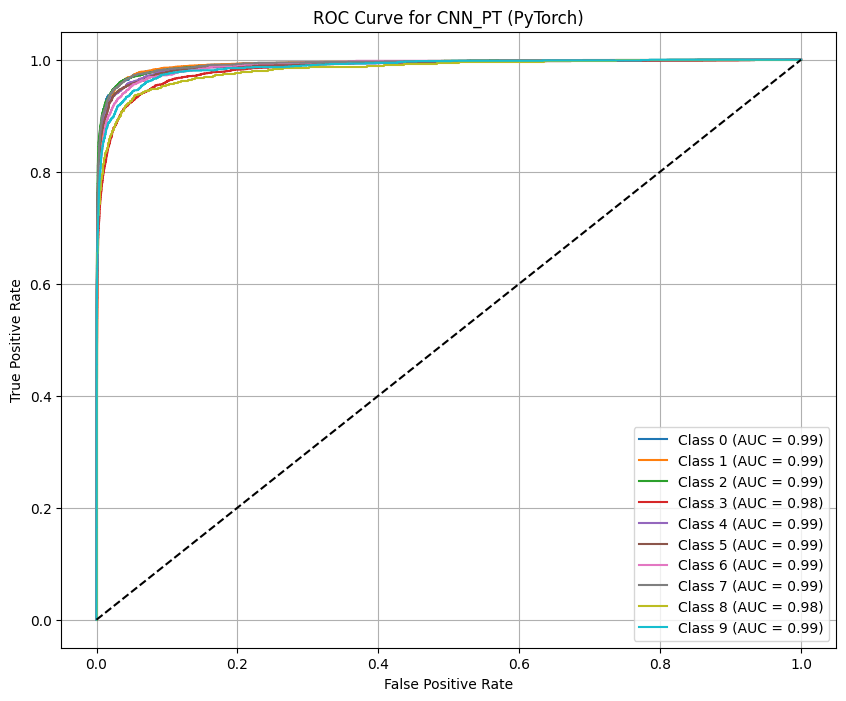

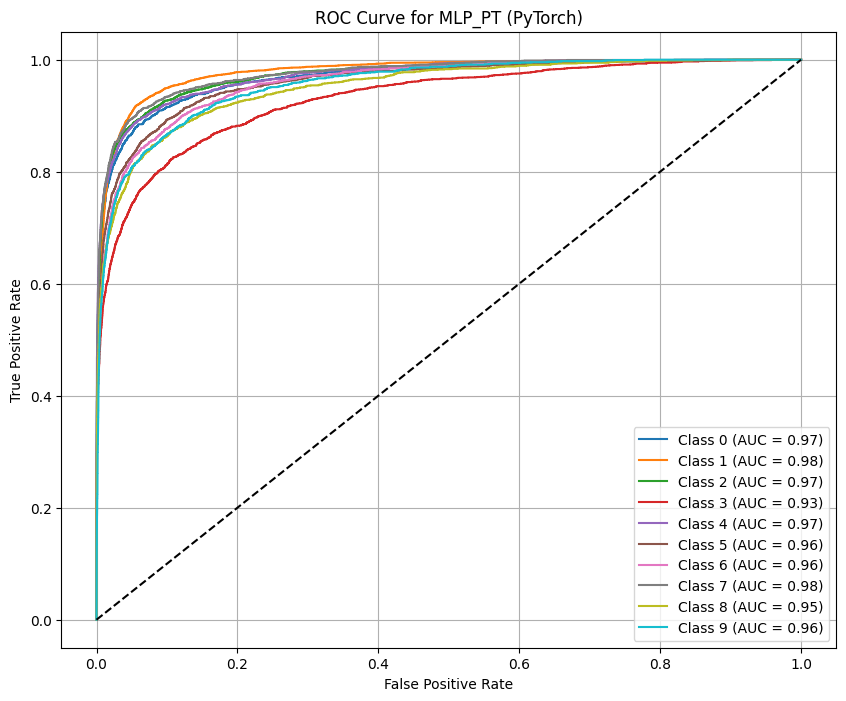

In [15]:
plot_roc_pt(cnn_pt, test_loader_pt, "CNN_PT")
plot_roc_pt(mlp_pt, test_loader_pt, "MLP_PT")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━

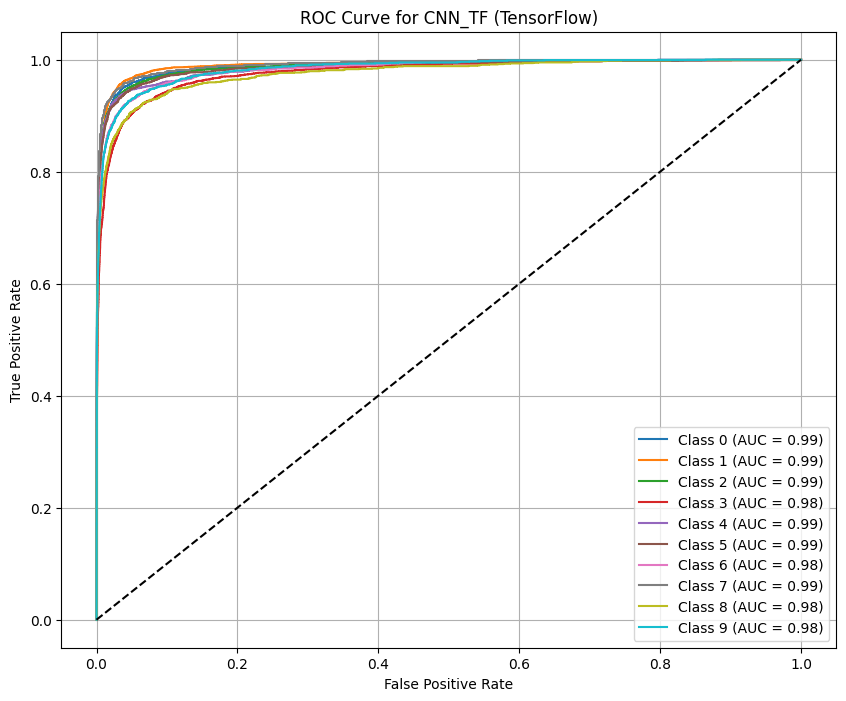

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━

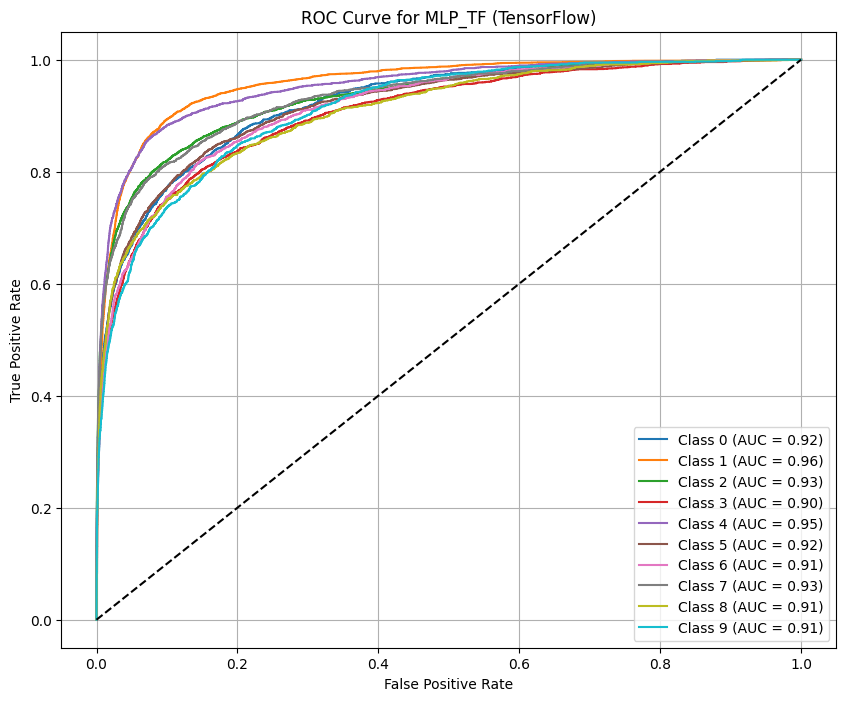

In [16]:
plot_roc_tf(cnn_tf, ds_test, "CNN_TF")
plot_roc_tf(mlp_tf, ds_test, "MLP_TF")

# Matriks Evaluasi
## **Accuracy**
Accuracy mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total data.

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

Di mana:  
- $TP$ = True Positive  
- $TN$ = True Negative  
- $FP$ = False Positive  
- $FN$ = False Negative  

Semakin tinggi **accuracy**, semakin baik performa model secara keseluruhan.

## **Precision**
Precision mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan total prediksi positif.

$$
Precision = \frac{TP}{TP + FP}
$$

Precision tinggi berarti model jarang salah dalam memprediksi kelas positif. Berguna ketika **false positive** harus diminimalkan, misalnya dalam **deteksi kanker**.

## **Recall**
Recall mengukur seberapa banyak sampel positif yang benar-benar terdeteksi oleh model.

$$
Recall = \frac{TP}{TP + FN}
$$

Recall tinggi berarti model tidak melewatkan banyak sampel positif. Sangat penting dalam **deteksi penyakit atau penipuan**, di mana **false negative** harus diminimalkan.

##**F1 Score**
F1 Score adalah rata-rata harmonik antara Precision dan Recall. Berguna saat dataset tidak seimbang.

$$
F1\ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

F1 Score tinggi berarti keseimbangan yang baik antara Precision dan Recall.

## **ROC dan AUC**
ROC (**Receiver Operating Characteristic**) adalah kurva yang menunjukkan trade-off antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**.

$$
TPR = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{FP + TN}
$$

Jika nilai semakin mendekati 1, semakin bagus modelnya. Sedangkan jika nilai di bawah 0.5, model tersebut lebih buruk dari tebakan acak.